In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python-headless numpy

In [1]:
#connect drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd '/content/gdrive/MyDrive/Thesis/Demo_code/rex'

/content/gdrive/MyDrive/Thesis/Demo_code/rex


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from tensorflow import keras
import shutil

In [ ]:
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from itertools import combinations
from collections import defaultdict
import itertools
import functools

In [ ]:
def showImage(image_path):
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [ ]:
def detectId(correct_image):
  cropped_id = correct_image[320:390,1025:1340]
  return cropped_id

[310:376,1055:1375]


In [ ]:
def detectSection(correct_image):
  cropped_section = correct_image[480:535,1025:1340]
  return cropped_section

In [ ]:
def detectDate1(correct_image):
  cropped_section = correct_image[1300:1380,950:1250]
  return cropped_section

In [ ]:
def detectDate2(correct_image):
  cropped_section = correct_image[1800:1920,1000:1350]
  return cropped_section

In [ ]:
def detectCode(correct_image):
  cropped_section = correct_image[400:480,1140:1340]
  return cropped_section

[455:523,1040:1375]



In [ ]:
def detectGrades(correct_image):
  cropped_grades=[]
  y_start=760
  y_end=810
  x_start=390
  x_end=550
  h=10
  cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  #cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  y_start+=45
  y_end+=45
  cropped_grades.append(correct_image[y_start-h:y_end-h, x_start-h:x_end-h])
  return cropped_grades


  y_start=750
  y_end=799
  x_start=387
  x_end=549
  y_start+=50

In [ ]:
def remove_lines_and_dots(image, min_size_threshold=1, max_size_threshold=5, min_width_threshold=5, max_width_threshold=20):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to binarize the image
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # used to send

    # Find horizontal lines using a kernel
    kernel = np.ones((1, 5), np.uint8)
    lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours of the lines and dots
    contours, _ = cv2.findContours(lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove horizontal lines and small dots based on the size thresholds
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        #print("w",w," h",h)
        if  min_width_threshold < w < max_width_threshold :
            image[y:y+h, x:x+w] = 0 # Set the region to black
        if  h >= max_size_threshold:
            image[y:y+h, x:x+w] = 255 # Set the region to white

    #cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return image

def segment_and_save_digits(img, output_folder): #PASS IMG HERE
    # Read the input image
    original_image = img.copy()

    # Remove horizontal lines from each digit
    cleaned_original_image = remove_lines_and_dots(original_image)

    # Convert the cleaned image to grayscale
    #gray_image = cleaned_original_image.copy()
    gray_image = cv2.cvtColor(cleaned_original_image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to binarize the image
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours based on x-coordinate
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Collect information about each segmented digit's size
    digit_sizes = []

    # Iterate through the contours
    for idx, contour in enumerate(contours):
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Extract each digit from the original image
        digit = cleaned_original_image[y:y + h, x:x + w]

        # Save each digit as a separate image
        digit_path = os.path.join(output_folder, f'digit_{idx + 1}.png')
        cv2.imwrite(digit_path, digit)

        # Append the size of the digit to the list
        digit_sizes.append((w, h))

        # Draw a rectangle around the digit on the original image
        cv2.rectangle(cleaned_original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the result
    #cv2_imshow(cleaned_original_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Return the list of digit sizes
    return digit_sizes

def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        #print(f"Error: {e}")
        return None

def is_low_pixel_count(image_path, threshold):
    # Read the image
    image = cv2.imread(image_path)

    # Get the total number of pixels in the image
    total_pixels = image.size

    # Print the pixel count and image name
    #print(f"Image: {os.path.basename(image_path)}, Pixel Count: {total_pixels}")

    # Set a threshold for low pixel count (adjust as needed)
    if total_pixels < threshold:
        return True
    else:
        return False

def filter_images_by_pixel_count(folder_path, output_folder, threshold):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all files in the folder
    i=0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Construct the full path to the image
            image_path = os.path.join(folder_path, filename)

            # Check if the image has a low pixel count
            if is_low_pixel_count(image_path, threshold):
                #print(f"Removing image: {filename}")
                continue  # Skip this image

            # Copy the image to the output folder #str(i)+".jpg"
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cv2.imread(image_path))

def extract_region(image_path, target_width, target_height):
    try:
        with Image.open(image_path) as img:
            width, height = img.size

            # Define the crop coordinates
            crop_width = 7
            crop_height = height
            crop_left = width - crop_width
            crop_right = width

            # Crop the right 7x21 pixels
            cropped_image = img.crop((crop_left, 0, crop_right, crop_height))

            # Save the cropped image
            cropped_image.save('digit_ex1.png')

            # Save the remaining part of the image
            remaining_image = img.crop((0, 0, crop_left, crop_height))
            remaining_image.save('digit_ex2.png')

            #print("Cropped and saved successfully.")
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
def segmentation(img):
  output_folder = '/content/gdrive/MyDrive/Thesis/OCR_Implementation/Processed_Image/digit'
  digit_sizes = segment_and_save_digits(img, output_folder)

  # Display the sizes of each segmented digit
  #for idx, size in enumerate(digit_sizes):
  #    print(f"Digit {idx + 1} Size: {size[0]} x {size[1]} pixels")

  # # Example usage
  input_folder = '/content/gdrive/MyDrive/Thesis/OCR_Implementation/Processed_Image/digit'
  output_folder = '/content/gdrive/MyDrive/Thesis/OCR_Implementation/Processed_Image/digit_cleaned'
  pixel_count_threshold = 300 # Adjust as needed

  filter_images_by_pixel_count(input_folder, output_folder, pixel_count_threshold)

  segmented_images=[]
  path = '/content/gdrive/MyDrive/Thesis/OCR_Implementation/Processed_Image/digit_cleaned'
  files = os.listdir(path)
  for file_name in files:
    tmpImg=cv2.imread(path+'/'+file_name)
    segmented_images.append(tmpImg)
  try:
      shutil.rmtree('/content/gdrive/MyDrive/Thesis/OCR_Implementation/Processed_Image')
  except Exception as e:
      print(f'Failed to delete directory: {e}')
  return segmented_images

In [ ]:
%cd '/content/gdrive/MyDrive/Thesis/Cropped Digits'

/content/gdrive/MyDrive/Thesis/Cropped Digits


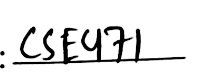

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/Thesis/Scanned/3.jpg")
img_resized=cv2.resize(img, (1500, 2000))

dateOne = img_resized[400:480,1140:1340]

cv2_imshow(dateOne)


In [ ]:
#test
import uuid

def generateName(path,files):
  # Generate a unique ID
  while True:
    unique_id = uuid.uuid4()

    if unique_id not in files:
      break
  return path+"/"+str(unique_id)+".jpg"

#image_path = path+'/2.jpg'
path = "/content/gdrive/MyDrive/Thesis/Scanned"
output_path = "/content/gdrive/MyDrive/Thesis/Cropped Digits"
for index in range (1,8):
  image_path=path+'/'+str(index)
  files=os.listdir(image_path)
  for filename in files:
    img = cv2.imread(image_path+"/"+filename)

    img_resized=cv2.resize(img, (1500, 2000))

    id = detectId(img_resized)
    section = detectSection(img_resized)
    grades = detectGrades(img_resized)

    dateOne = detectDate1(img_resized)
    dateTwo = detectDate2(img_resized)
    courseCode = detectCode(img_resized)

    cv2_imshow(id)
    segmentations = segmentation(id)
    for i in segmentations:
      name=generateName(output_path,files)
      output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

    cv2_imshow(section)
    segmentations = segmentation(section)
    for i in segmentations:
      name=generateName(output_path,files)
      output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

    #cv2_imshow(grades)
    for grade in grades:
      segmentations = segmentation(grade)
      for i in segmentations:
        name=generateName(output_path,files)
        output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

    cv2_imshow(courseCode)
    ##name=generateName(output_path,files)
    ##output = cv2.resize(i, (28, 28))
    ##cv2.imwrite(name,output)
    segmentations = segmentation(courseCode)
    for i in segmentations:
      name=generateName(output_path,files)
      output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

    cv2_imshow(dateOne)
    segmentations = segmentation(dateOne)
    for i in segmentations:
      name=generateName(output_path,files)
      output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

    cv2_imshow(dateTwo)
    segmentations = segmentation(dateTwo)
    for i in segmentations:
      name=generateName(output_path,files)
      output = cv2.resize(i, (28, 28))
      cv2.imwrite(name,output)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
import os

# Directory path
directory_path = "/content/gdrive/MyDrive/Thesis/Cropped Digits"

# List all files in the directory
files_list = os.listdir(directory_path)

# Count the number of files
number_of_files = len(files_list)

print(f"Number of files in '{directory_path}': {number_of_files}")
i=0
for filename in files_list:
  print(filename, i)
  i+=1


Streaming output truncated to the last 5000 lines.
bf8d8873-f82d-49d7-8210-bb4b48373807.jpg 6551
b5ba38a3-5c96-4f61-aff6-a409a5529b36.jpg 6552
d814f94e-5be8-48b4-a9ab-59a0fe37e1ca.jpg 6553
f9395391-99f1-41d4-adef-46beae897484.jpg 6554
66f76d82-559a-440d-a378-89cfe0f4c5cc.jpg 6555
77d16f88-8ceb-466a-923a-c94a8b51c90d.jpg 6556
4f6e10ac-60da-4e9c-8fc8-54e98cce4b19.jpg 6557
be118eb7-4483-4daf-85a4-6899e99fec38.jpg 6558
114568a2-49b1-4c6f-b0da-702e68fea300.jpg 6559
20720586-d371-474e-9cc9-3f502f15ee20.jpg 6560
587f568b-ee82-429a-8687-fe58bc173a74.jpg 6561
45ef727a-53f4-4849-b3c0-71e039a77ee2.jpg 6562
aad377ad-5a21-47ae-b673-b906225c8967.jpg 6563
7112a34f-0cb4-44fe-9d0a-b458d9b82831.jpg 6564
be639683-0ba4-455d-ad38-5bfd22031363.jpg 6565
aa331854-5fca-4a2a-ae71-323df148decf.jpg 6566
d2676713-2b2f-4356-80c0-eec13e86a1ec.jpg 6567
00715987-a36b-41bd-bec9-7e0ad393efe8.jpg 6568
758bdf30-bde2-44d4-9c68-dd5236c34ea6.jpg 6569
6cc1ad3c-692b-4260-8014-4332c8d9ba73.jpg 6570
cb759ee2-c861-458a-abf4-bd1e5

In [3]:
import cv2
import os

mysha="/content/gdrive/MyDrive/Thesis/Mysha/"
tasnim="/content/gdrive/MyDrive/Thesis/Tasnim/"

directory_path = "/content/gdrive/MyDrive/Thesis/Cropped Digits"

files_list = os.listdir(directory_path)

index=1

for filename in files_list:
  if index<5776:
    img=cv2.imread(directory_path+"/"+filename)
    print(mysha+str(index)+".jpg")
    cv2.imwrite(mysha+str(index)+".jpg",img)
  else:
    tmg=cv2.imread(directory_path+"/"+filename)
    print(tasnim+str(index)+".jpg")
    cv2.imwrite(tasnim+str(index)+".jpg",tmg)
  index+=1

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/Thesis/Tasnim/6552.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6553.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6554.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6555.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6556.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6557.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6558.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6559.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6560.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6561.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6562.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6563.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6564.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6565.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6566.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6567.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6568.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6569.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6570.jpg
/content/gdrive/MyDrive/Thesis/Tasnim/6571.jpg
/content/

In [19]:
import os

# Directory path
directory_path = "/content/gdrive/MyDrive/Thesis/Tasnim"

# List all files in the directory
files_list = os.listdir(directory_path)

# Count the number of files
number_of_files = len(files_list)

print(f"Number of files in '{directory_path}': {number_of_files}")


Number of files in '/content/gdrive/MyDrive/Thesis/Tasnim': 5776
